# Group 20 Sprint 2 Code

#Imports and definitions:

In [1]:
#@title
import numpy as np
import requests
import io
from torch.utils.data import TensorDataset
import matplotlib.pyplot as plt
import torch
from scipy.ndimage import rotate
%matplotlib inline
from torch.utils.data import Dataset
import random
import torch
import torchvision.transforms as transforms
from sklearn.model_selection import train_test_split
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchsummary import summary
from tqdm import tqdm

class BatchSampler():
  """
  Implements an iterable which given a torch dataset and a batch_size
  will produce batches of data of that given size. The batches are
  returned as tuples in the form (images, labels).
  Can produce balanced batches, where each batch will have an equal 
  amount of samples from each class in the dataset. If your dataset is heavily
  imbalanced, this might mean throwing away a lot of samples from 
  over-represented classes!
  """

  def __init__(self, batch_size, dataset, balanced=False):
    self.batch_size = batch_size
    self.dataset = dataset
    self.balanced = balanced
    if self.balanced:
      # Counting the ocurrence of the class labels:
      unique, counts = np.unique(self.dataset.targets, return_counts=True) 
      indexes = []
      # Sampling an equal amount from each class:
      for i in range(len(unique)):
        indexes.append(np.random.choice(np.where(self.dataset.targets == i)[0], size=counts.min(), replace=False))
      # Setting the indexes we will sample from later:
      self.indexes = np.concatenate(indexes)
    else:
      # Setting the indexes we will sample from later (all indexes):
      self.indexes = [i for i in range(len(dataset))]


  def __len__(self):
    return (len(self.indexes) // self.batch_size) + 1
  
  def shuffle(self):
    # We do not need to shuffle if we use the balanced sampling method.
    # Shuffling is already done when making the balanced samples.
    if not self.balanced:
      random.shuffle(self.indexes)
    
  def __iter__(self):
    remaining = False
    self.shuffle()
    # Go over the datset in steps of 'self.batch_size':
    for i in range(0, len(self.indexes), self.batch_size):
        imgs, labels = [], []
        # If our current batch is larger than the remaining data, we quit:
        if i + self.batch_size > len(self.indexes):
          remaining = True
          break
        # If not, we yield a complete batch:
        else:
          # Getting a list of samples from the dataset, given the indexes we defined:
          X_batch = [self.dataset[self.indexes[k]][0] for k in range(i, i + self.batch_size)]
          Y_batch = [self.dataset[self.indexes[k]][1] for k in range(i, i + self.batch_size)]
          # Stacking all the samples and returning the target labels as a tensor:
          yield torch.stack(X_batch).float(), torch.tensor(Y_batch).long()
    # If there is still data left that was not a full batch:
    if remaining:
      # Return the last batch (smaller than batch_size):
      X_batch = [self.dataset[self.indexes[k]][0] for k in range(i, len(self.indexes))]
      Y_batch = [self.dataset[self.indexes[k]][1] for k in range(i, len(self.indexes))]
      yield torch.stack(X_batch).float(), torch.tensor(Y_batch).long()

class ImageDataset(Dataset):
  """
  Creates a DataSet from numpy arrays while keeping the data 
  in the more efficient numpy arrays for as long as possible and only
  converting to torchtensors when needed (torch tensors are the objects used
  to pass the data through the neural network and apply weights).
  """
  
  def __init__(self, x, y, transform=None, target_transform=None):
    self.targets = y
    self.imgs = x
    self.transform = transform
    self.target_transform = target_transform

  def __len__(self):
    return len(self.targets)

  def __getitem__(self, idx):
    image = torch.from_numpy(self.imgs[idx] / 255).float()
    label = self.targets[idx]
    return image, label

def load_numpy_arr_from_url(url):
    """
    Loads a numpy array from surfdrive. 
    
    Input:
    url: Download link of dataset 
    
    Outputs:
    dataset: numpy array with input features or labels
    """
    
    response = requests.get(url)
    response.raise_for_status()

    return np.load(io.BytesIO(response.content)) 


class_labels = {0: 'Atelectasis',
                1: 'Effusion',
                2: 'Infiltration',
                3: 'No Finding',
                4: 'Nodule',
                5: 'Pneumothorax'}

# Downloading the data:
The following cells will download the pre-processed X-ray images with their accompanying labels.

The download (400 MB) may take a while.

In [2]:
#@title
# Downloading the labels of each image:
train_y = load_numpy_arr_from_url('https://surfdrive.surf.nl/files/index.php/s/i6MvQ8nqoiQ9Tci/download')
test_y = load_numpy_arr_from_url('https://surfdrive.surf.nl/files/index.php/s/wLXiOjVAW4AWlXY/download')

In [3]:
#@title
# Downloading the images:
train_x = load_numpy_arr_from_url('https://surfdrive.surf.nl/files/index.php/s/4rwSf9SYO1ydGtK/download')
test_x = load_numpy_arr_from_url('https://surfdrive.surf.nl/files/index.php/s/dvY2LpvFo6dHef0/download')

# Data Augmentation


In [4]:
low_brightness = []
minimum = 1100000
for l in range(len(train_x)):
  if train_x[l].sum() < minimum: 
    low_brightness.append(l)
low_brightness

[187,
 217,
 243,
 542,
 620,
 1513,
 2266,
 2306,
 2321,
 2323,
 2448,
 2550,
 2623,
 2682,
 4067,
 4194,
 4880,
 5430,
 5465,
 5876,
 5980,
 6124,
 6607,
 6871,
 7326,
 7675,
 8027,
 8186,
 8219,
 8933,
 9195,
 9410,
 9633,
 9662,
 9950,
 10081,
 10443,
 10578,
 10986,
 11304,
 11405,
 11479,
 11638,
 11985,
 12228,
 12489,
 12662,
 14658,
 14789,
 14877,
 15559,
 15731,
 15877,
 15962]

In [5]:
all = []
for i in range(len(train_x)):
  all.append(i)

for item in low_brightness: 
  all.remove(item)

In [6]:
new_train_x = train_x[all]
new_train_y = train_y[all]

In [7]:
trans = transforms.Compose([
    transforms.ToPILImage(),
    transforms.Resize((256,256)),
    transforms.RandomInvert(p=0.9),
    transforms.RandomAdjustSharpness(2, p=0.9),
    transforms.RandomRotation(270),
    transforms.RandomHorizontalFlip(p=0.4),
    transforms.RandomVerticalFlip(p=0.2),
    transforms.CenterCrop((200,200)),
    transforms.AutoAugment(),
    transforms.PILToTensor(),
    transforms.Lambda(lambda x: torch.cat([x, x, x], 0)),
])

# Plotting the data distribution:

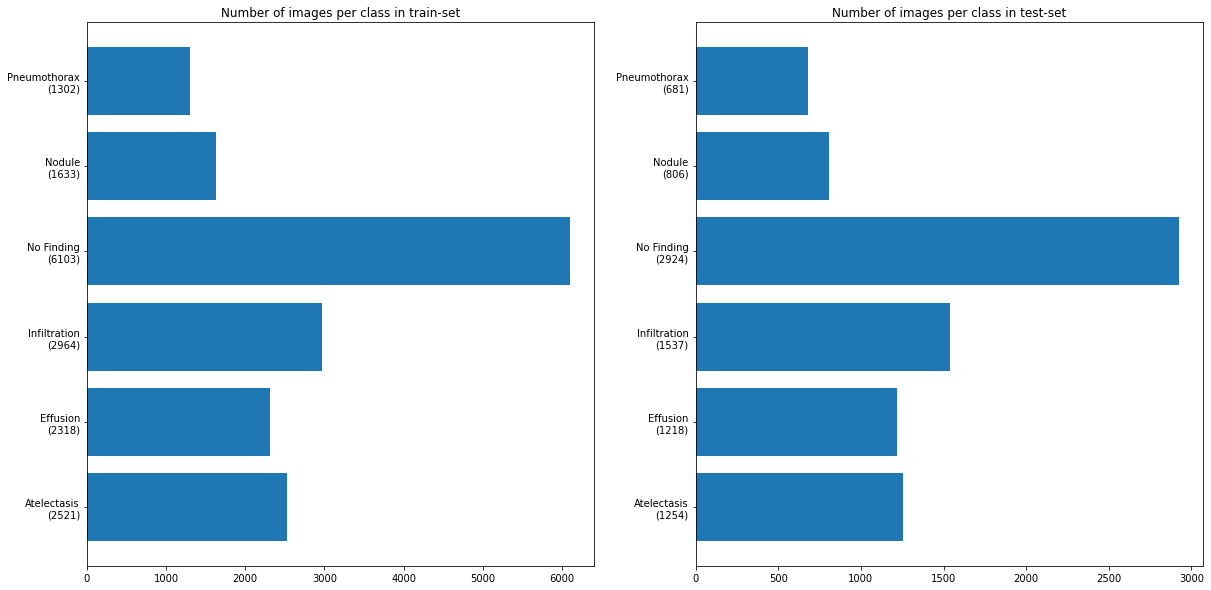

In [8]:
#@title
# Plotting the label distribution in train/test set:
fig, ax = plt.subplots(ncols=2, figsize=[20,10])

unique, counts = np.unique(train_y, return_counts=True) 
ax[0].barh([class_labels[i] + f'\n({c})' for i, c in zip(unique, counts)], counts)
ax[0].set_title('Number of images per class in train-set')

unique, counts = np.unique(test_y, return_counts=True) 
ax[1].barh([class_labels[i] + f'\n({c})' for i, c in zip(unique, counts)], counts)
ax[1].set_title('Number of images per class in test-set');

#Plotting some samples:

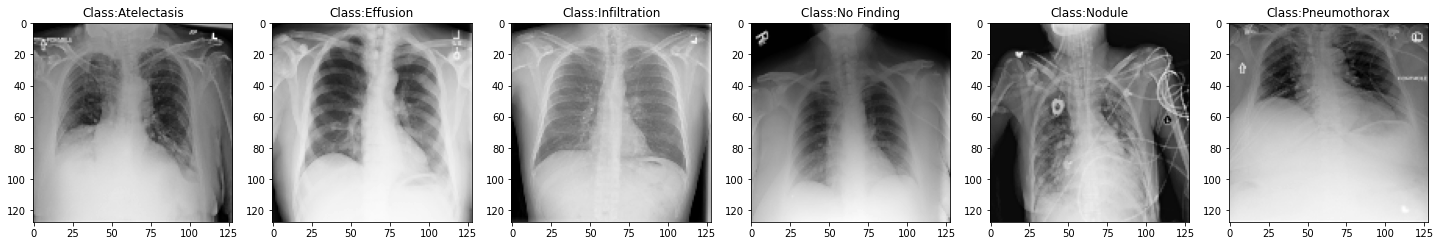

In [9]:
#@title
# Plotting some images
unique_labels = set(class_labels.keys())
fig, ax = plt.subplots(ncols=len(unique_labels), figsize=[25,5])

for k, label in enumerate(unique_labels):
  ind = list(train_y).index(label)
  ax[k].imshow(train_x[ind].reshape(128,128), cmap='gray')
  ax[k].set_title(f'Class:{class_labels[train_y[ind]]}')

# Building torch datasets:

In [10]:
#@title
train_dataset = ImageDataset(new_train_x, new_train_y, transform = trans)
test_dataset = ImageDataset(test_x, test_y, transform = trans)

In [11]:
device = ('cuda' if torch.cuda.is_available() else 'cpu')
device 

'cuda'

In [12]:
for i in tqdm(train_dataset):
    images, labels = i

100%|██████████| 16787/16787 [00:02<00:00, 7253.04it/s]


# Neural Network


In [13]:
class Net(nn.Module):   
    def __init__(self, n_classes):
        super(Net, self).__init__()

        self.cnn_layers = nn.Sequential(
            # Defining a 2D convolution layer
            nn.Conv2d(1, 64, kernel_size=4, stride=1),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=4),
            torch.nn.Dropout(p=0.5, inplace=True),
            # Defining another 2D convolution layer
            nn.Conv2d(64, 32, kernel_size=4, stride=1),
            nn.BatchNorm2d(32),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=3),
            torch.nn.Dropout(p=0.25, inplace=True),
            # Defining another 2D convolution layer
            nn.Conv2d(32, 16, kernel_size=4, stride=1),
            nn.BatchNorm2d(16),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2),
            torch.nn.Dropout(p=0.125, inplace=True),
        )

        self.linear_layers = nn.Sequential(
            nn.Linear(144, 256),
            nn.Linear(256, n_classes)
        )

    # Defining the forward pass    
    def forward(self, x):
        x = self.cnn_layers(x)
        # After our convolutional layers which are 2D, we need to flatten our
        # input to be 1 dimensional, as the linear layers require this.
        x = x.view(x.size(0), -1)
        x = self.linear_layers(x)
        return x

# Make sure your model instance is assigned to a variable 'model':
model = Net(n_classes = 6).to(device)

# Optimizer and Loss Functions

In [14]:
optimizer = optim.Adam(model.parameters(), lr=0.001)
loss_function = nn.CrossEntropyLoss()

# Training and Testing definitions

In [15]:
#@title
def train_model(model, train_sampler, optimizer, loss_function):
  # Lets keep track of all the losses:
  losses = []
  # Put the model in train mode:
  model.train()
  # Feed all the batches one by one:
  for batch in tqdm(train_sampler):
    # Get a batch:
    x, y = batch
    # Making sure our samples are stored on the same device as our model:
    x, y = x.to(device), y.to(device)
    # Get predictions:
    predictions = model.forward(x)
    loss = loss_function(predictions, y)
    losses.append(loss)
    # We first need to make sure we reset our optimizer at the start.
    # We want to learn from each batch seperately, 
    # not from the entire dataset at once.
    optimizer.zero_grad()
    # We now backpropagate our loss through our model:
    loss.backward()
    # We then make the optimizer take a step in the right direction.
    optimizer.step()
  return losses

def test_model(model, test_sampler, loss_function):
  # Setting the model to evaluation mode:
  model.eval()
  losses = []
  # We need to make sure we do not update our model based on the test data:
  with torch.no_grad():
    for (x, y) in tqdm(test_sampler):
      # Making sure our samples are stored on the same device as our model:
      x = x.to(device)
      y = y.to(device)
      prediction = model.forward(x)
      loss = loss_function(prediction, y)
      losses.append(loss)
  return losses

# Training and test procedures


In [16]:
n_epochs = 2
batch_size = 25

In [17]:
torch.cuda.empty_cache()
import gc
gc.collect()

5280

# K-Fold

In [18]:
from torch.utils.data import ConcatDataset
from sklearn.model_selection import KFold


dataset = ConcatDataset([train_dataset, test_dataset])
k = 10
num_epochs = 2
splits = KFold(n_splits=k,shuffle=True,random_state=42)
foldperf = {}

Fold 1


100%|██████████| 1009/1009 [00:38<00:00, 26.17it/s]



Epoch 1 training done, loss on train set: 1.609619140625



100%|██████████| 253/253 [00:13<00:00, 18.88it/s]



Epoch 1 testing done, loss on test set: 1.5906649827957153



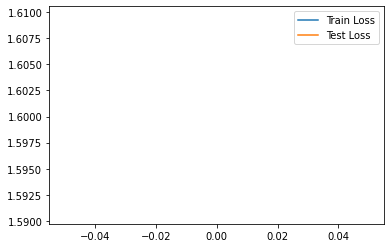

100%|██████████| 1009/1009 [00:38<00:00, 26.25it/s]



Epoch 2 training done, loss on train set: 1.5710253715515137



100%|██████████| 253/253 [00:13<00:00, 18.90it/s]



Epoch 2 testing done, loss on test set: 1.6140267848968506



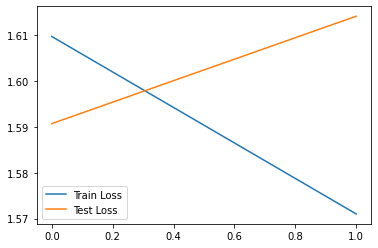

Fold 2


100%|██████████| 1009/1009 [00:38<00:00, 26.33it/s]



Epoch 1 training done, loss on train set: 1.5555111169815063



100%|██████████| 253/253 [00:13<00:00, 18.90it/s]



Epoch 1 testing done, loss on test set: 1.5181233882904053



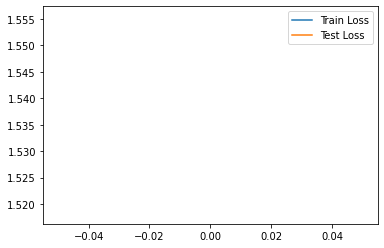

100%|██████████| 1009/1009 [00:38<00:00, 26.25it/s]



Epoch 2 training done, loss on train set: 1.5422182083129883



100%|██████████| 253/253 [00:13<00:00, 18.89it/s]



Epoch 2 testing done, loss on test set: 1.5248987674713135



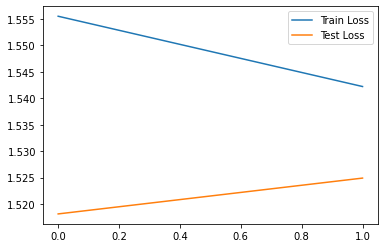

Fold 3


100%|██████████| 1009/1009 [00:38<00:00, 26.36it/s]



Epoch 1 training done, loss on train set: 1.532010793685913



100%|██████████| 253/253 [00:13<00:00, 18.91it/s]



Epoch 1 testing done, loss on test set: 1.5305531024932861



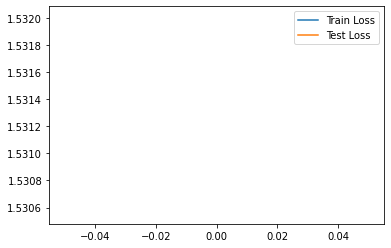

100%|██████████| 1009/1009 [00:38<00:00, 25.98it/s]



Epoch 2 training done, loss on train set: 1.52353036403656



100%|██████████| 253/253 [00:13<00:00, 18.88it/s]



Epoch 2 testing done, loss on test set: 1.498531699180603



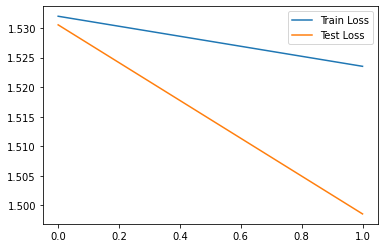

Fold 4


100%|██████████| 1009/1009 [00:38<00:00, 26.33it/s]



Epoch 1 training done, loss on train set: 1.5158976316452026



100%|██████████| 253/253 [00:13<00:00, 18.53it/s]



Epoch 1 testing done, loss on test set: 1.5039478540420532



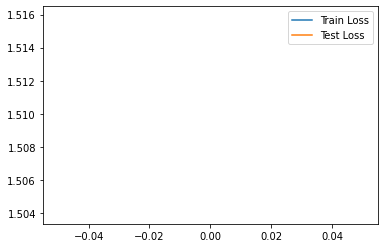

100%|██████████| 1009/1009 [00:38<00:00, 26.35it/s]



Epoch 2 training done, loss on train set: 1.5106042623519897



100%|██████████| 253/253 [00:13<00:00, 18.89it/s]



Epoch 2 testing done, loss on test set: 1.497330904006958



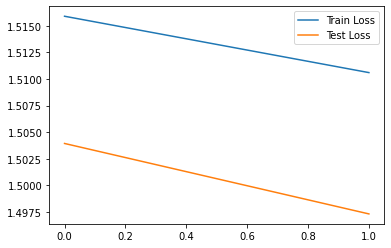

Fold 5


100%|██████████| 1009/1009 [00:38<00:00, 26.33it/s]



Epoch 1 training done, loss on train set: 1.502423644065857



100%|██████████| 253/253 [00:13<00:00, 18.90it/s]



Epoch 1 testing done, loss on test set: 1.486920952796936



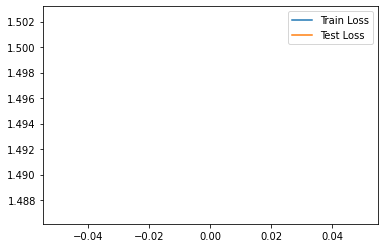

100%|██████████| 1009/1009 [00:38<00:00, 26.36it/s]



Epoch 2 training done, loss on train set: 1.4990657567977905



100%|██████████| 253/253 [00:13<00:00, 18.89it/s]



Epoch 2 testing done, loss on test set: 1.559065341949463



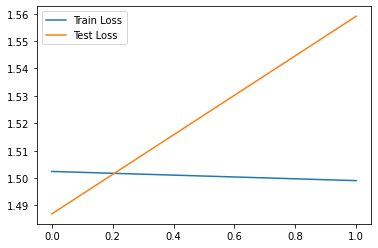

Fold 6


100%|██████████| 1009/1009 [00:38<00:00, 26.35it/s]



Epoch 1 training done, loss on train set: 1.493149757385254



100%|██████████| 253/253 [00:13<00:00, 18.89it/s]



Epoch 1 testing done, loss on test set: 1.5083988904953003



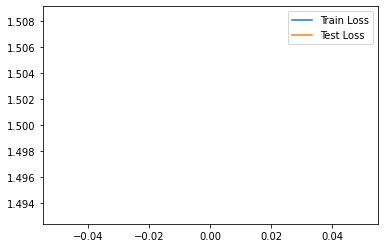

100%|██████████| 1009/1009 [00:38<00:00, 26.34it/s]



Epoch 2 training done, loss on train set: 1.4910708665847778



100%|██████████| 253/253 [00:13<00:00, 18.90it/s]



Epoch 2 testing done, loss on test set: 1.454860806465149



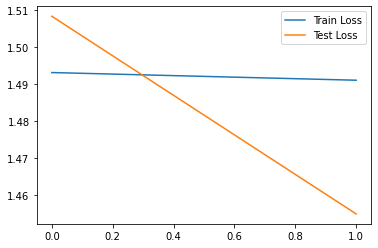

Fold 7


100%|██████████| 1009/1009 [00:38<00:00, 26.33it/s]



Epoch 1 training done, loss on train set: 1.4878662824630737



100%|██████████| 253/253 [00:13<00:00, 18.91it/s]



Epoch 1 testing done, loss on test set: 1.4650579690933228



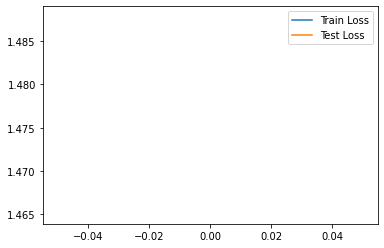

100%|██████████| 1009/1009 [00:38<00:00, 26.35it/s]



Epoch 2 training done, loss on train set: 1.4806582927703857



100%|██████████| 253/253 [00:13<00:00, 18.90it/s]



Epoch 2 testing done, loss on test set: 1.4543286561965942



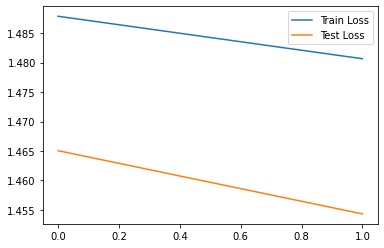

Fold 8


100%|██████████| 1009/1009 [00:38<00:00, 26.33it/s]



Epoch 1 training done, loss on train set: 1.4784959554672241



100%|██████████| 253/253 [00:13<00:00, 18.92it/s]



Epoch 1 testing done, loss on test set: 1.4631667137145996



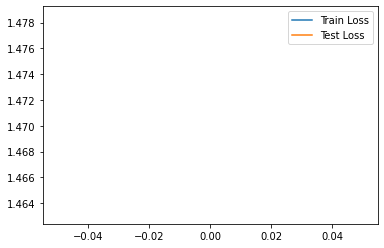

100%|██████████| 1009/1009 [00:38<00:00, 26.38it/s]



Epoch 2 training done, loss on train set: 1.4764536619186401



100%|██████████| 253/253 [00:13<00:00, 18.91it/s]



Epoch 2 testing done, loss on test set: 1.432388186454773



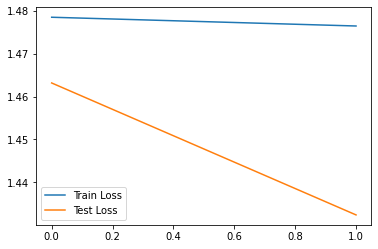

Fold 9


100%|██████████| 1009/1009 [00:38<00:00, 26.27it/s]



Epoch 1 training done, loss on train set: 1.473709225654602



100%|██████████| 253/253 [00:13<00:00, 18.89it/s]



Epoch 1 testing done, loss on test set: 1.5596585273742676



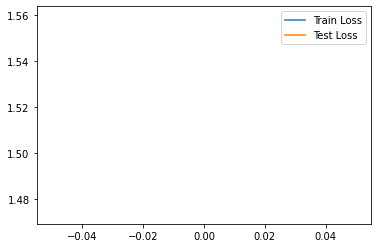

100%|██████████| 1009/1009 [00:38<00:00, 26.34it/s]



Epoch 2 training done, loss on train set: 1.4700819253921509



100%|██████████| 253/253 [00:13<00:00, 18.89it/s]



Epoch 2 testing done, loss on test set: 2.1111185550689697



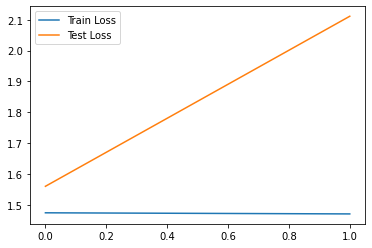

Fold 10


100%|██████████| 1009/1009 [00:38<00:00, 26.31it/s]



Epoch 1 training done, loss on train set: 1.4623862504959106



100%|██████████| 253/253 [00:13<00:00, 18.91it/s]



Epoch 1 testing done, loss on test set: 1.4724867343902588



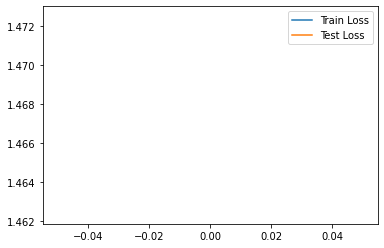

100%|██████████| 1009/1009 [00:38<00:00, 26.33it/s]



Epoch 2 training done, loss on train set: 1.463723063468933



100%|██████████| 253/253 [00:13<00:00, 18.90it/s]



Epoch 2 testing done, loss on test set: 1.4547959566116333



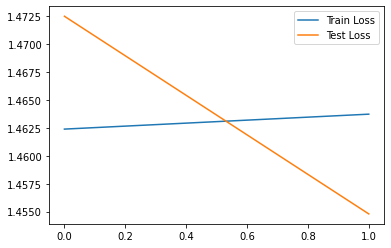

In [19]:
for fold, (train_idx,val_idx) in enumerate(splits.split(np.arange(len(dataset)))):

    print('Fold {}'.format(fold + 1))

  
    # Lets now train and test our model for multiple epochs:

    train_sampler = BatchSampler(batch_size=batch_size, dataset=dataset, balanced=False)
    test_sampler = BatchSampler(batch_size=100, dataset=dataset, balanced=False)

    mean_losses_train = []
    mean_losses_test = []
    accuracies = []
    for e in range(n_epochs):
            # Training:
            losses = train_model(model, train_sampler, optimizer, loss_function)
            # Calculating and printing statistics:
            mean_loss = sum(losses) / len(losses)
            mean_losses_train.append(mean_loss)
            print(f'\nEpoch {e + 1} training done, loss on train set: {mean_loss}\n')

            # Testing:
            losses = test_model(model, test_sampler, loss_function)
            # Calculating and printing statistics:
            mean_loss = sum(losses) / len(losses)
            mean_losses_test.append(mean_loss)
            print(f'\nEpoch {e + 1} testing done, loss on test set: {mean_loss}\n')
            
            fig, ax = plt.subplots()
            ax.plot([i.cpu().detach().numpy() for i in mean_losses_train], label='Train Loss')
            ax.plot([i.cpu().detach().numpy() for i in mean_losses_test], label='Test Loss')
            ax.legend()
            plt.show();   

# Evaluating our model

In [20]:
model.eval()
# We need to make sure we do not update our model based on the test data:
with torch.no_grad():
  correct = 0
  count = 0
  for (x, y) in tqdm(test_sampler):
    # Making sure our samples are stored on the same device as our model:
    x = x.to(device)
    y = y.to(device)
    prediction = model.forward(x).argmax(axis=1)
    correct += sum(prediction == y)
    count += len(y)
accuracy = (correct/count).detach().cpu().numpy()
print(f'\nAccuracy of model on test set: {accuracy}')

100%|██████████| 253/253 [00:13<00:00, 18.62it/s]


Accuracy of model on test set: 0.430475652217865


# Obtain predicted and test values


In [21]:
def y_value_gen(model, train_sampler):
        '''
        function that returns a list of true and predicted values
        when given a model and the train/test train_sampler
        '''
        model.eval()
        # We need to make sure we do not update our model based on the test data:
        with torch.no_grad():

                #create lists that store true and pred labels
                y_pred = []
                y_true = []

                # iterate over train data batch
                for inputs, labels in tqdm(train_sampler):
                        inputs, labels = inputs.to(device), labels.to(device)
                        output = model(inputs) 

                        output = (torch.max(torch.exp(output), 1)[1]).data.cpu().numpy()
                        y_pred.extend(output) # Save Prediction
                        
                        labels = labels.data.cpu().numpy()
                        y_true.extend(labels) # Save Truth

                return y_true, y_pred

y_true, y_pred = y_value_gen(model, train_sampler)

100%|██████████| 1009/1009 [00:22<00:00, 45.23it/s]


# Building a confusion matrix


In [22]:
# Import useful libraries
from sklearn.metrics import confusion_matrix
import seaborn as sns
import pandas as pd
pd.set_option('display.float_format', lambda x: '%.5f' % x)
import matplotlib as mpl
mpl.rcParams['figure.dpi'] = 75
from sklearn import metrics
from sklearn.metrics import RocCurveDisplay
from sklearn.metrics import accuracy_score
from sklearn.metrics import roc_curve
from sklearn.metrics import precision_score, recall_score
from sklearn.metrics import classification_report

In [23]:
def confusion_matrix_gen(y_true, y_pred, cmap=str):

        # Build confusion matrix
        cf_matrix = confusion_matrix(y_true, y_pred)
        target_names = [items[1] for items in class_labels.items()]

        df_cm = pd.DataFrame(cf_matrix, index = target_names,
                                columns = target_names)
        plt.figure(figsize = (12,7))

        c = 'plt.cm.' + cmap
        sns.heatmap(df_cm, annot=True, fmt='g', cmap=eval(c))
        plt.ylabel('True Label', weight='bold', size=12)
        plt.xlabel('Predicted Label', weight='bold',size=12)
        plt.title('Confusion Matrix of True vs Predited Labels', weight='bold', size=16)
        plt.savefig('output.png')

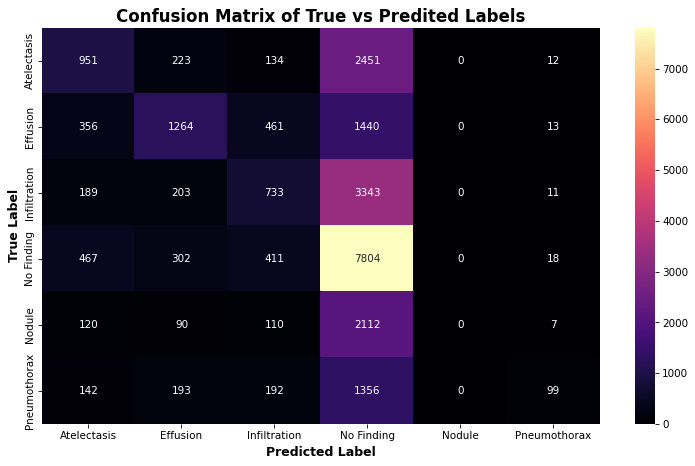

In [24]:
# Confusion matrix for the test data
confusion_matrix_gen(y_true, y_pred, 'magma')

# More metrics evalutaion


Run the cell below only once for installing the torchmetrics package.

In [26]:
!pip install torchmetrics

     |████████████████████████████████| 332 kB 13.5 MB/s 


In [27]:
import torchmetrics
acc = torchmetrics.Accuracy()
f1_score = torchmetrics.F1()
precision = torchmetrics.Precision(num_classes=6, average='micro')   #calculate precision globally across all samples and classes
recall = torchmetrics.Recall(num_classes=6,average='macro')

 **Function that generates ROC curve for all labels**






In [28]:
def roc_curve_gen(y_true, y_pred):
    '''
    takes true and predicted labels lists as input
    and generates a roc curve for each class label
    '''
    
    fpr = dict()
    tpr = dict()
    threshold = dict()

    target_names = [items[1] for items in class_labels.items()]

    for i in range(len(class_labels)):
        fpr[i], tpr[i], threshold[i] = roc_curve(y_true, y_pred, pos_label=i)

    
    mpl.rcParams['figure.dpi'] = 100
    # Plot ROC curve
    for i in range(len(class_labels)):
        plt.plot(fpr[i], tpr[i], label="ROC Curve of {label}".format(label=target_names[i]))

    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Curve for Multiclass')
    plt.legend(loc="lower right", prop={'size': 8})
    plt.show()

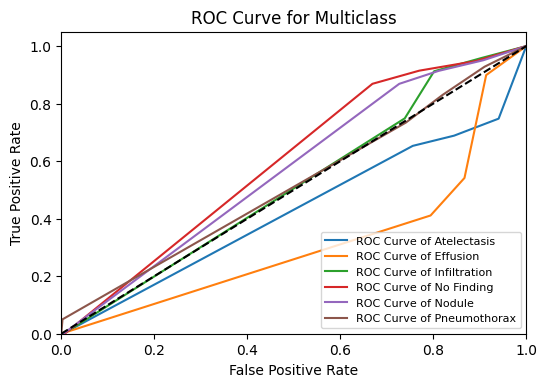

In [29]:
roc_curve_gen(y_true, y_pred)

**Additional metrics per label**

In [30]:
def metrics_gen(y_true, y_pred):
    '''
    takes true and predicted labels lists as input
    and returns a summarised metrics report
    '''
    target_names = [items[1] for items in class_labels.items()]
    return metrics.classification_report(y_true, y_pred, output_dict=True, target_names=target_names, zero_division=1)

metrics_gen(y_true, y_pred)

{'Atelectasis': {'f1-score': 0.31721147431621083,
  'precision': 0.42741573033707864,
  'recall': 0.25218774860779636,
  'support': 3771},
 'Effusion': {'f1-score': 0.4351867791358237,
  'precision': 0.5556043956043956,
  'recall': 0.3576683644595359,
  'support': 3534},
 'Infiltration': {'f1-score': 0.2248466257668712,
  'precision': 0.3591376776090152,
  'recall': 0.16365260102701495,
  'support': 4479},
 'No Finding': {'f1-score': 0.5673985749600117,
  'precision': 0.4217010699232681,
  'recall': 0.8669184625638747,
  'support': 9002},
 'Nodule': {'f1-score': 0.0, 'precision': 1.0, 'recall': 0.0, 'support': 2439},
 'Pneumothorax': {'f1-score': 0.09243697478991596,
  'precision': 0.61875,
  'recall': 0.04994954591321897,
  'support': 1982},
 'accuracy': 0.4304756615225929,
 'macro avg': {'f1-score': 0.2728467381614722,
  'precision': 0.5637681455789595,
  'recall': 0.28172945376190683,
  'support': 25207},
 'weighted avg': {'f1-score': 0.3583200952015665,
  'precision': 0.50166159569